# Recommendation system for arXiv manuscripts by Peter Boross

In [1]:
import time
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import warnings
import time
import json
import arxiv
import sqlite3
import urllib.request as libreq
import re
from collections import Counter
import unidecode
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import auc, plot_roc_curve, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  StratifiedShuffleSplit
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import wordcloud

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /Users/bope/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Helper functions

In [2]:
def get_authors_FLast(authors):
    r = []
    for author in authors:
        if len(author[1]) == 0: r.append(unidecode.unidecode(author[0]))
        else: r.append(unidecode.unidecode(author[1][0]+author[0]))    
    return ' '.join(r)

def get_authors_FLast_arxivapi(authors):
    r = []
    for authorv in authors:
        author = authorv.split(' ')
        r.append(unidecode.unidecode(author[0][0]+author[-1]))    
    return ' '.join(r)

def get_authors_FdotLastcomma(authors):
    r = []
    for author in authors:
        authorv = author.split(' ')
        r.append(unidecode.unidecode(' '.join([x[0]+'.' for x in authorv[0:-1]])+' '+authorv[-1]))
    return ', '.join(r)

def progress_bar(relevance):
    s = 100-int(100-100*relevance/5)
    if s > 14:
        if s > 17:
            color = 'red'
        else:
            color = 'orange'
    else:
        color = 'yellow'
    return '|<font color="'+color+'">'+'█'*s+'</font>'+'-'*(20-s)+'|'

def print_score_oneline(scores, type, train):
    extra_space = 9
    string = ''
    if train:
        string = 'train '+type+' '*(extra_space-len(type))+' = '+'{:.1f}%\t\t'.format(100*np.mean(scores['train_'+type]))
    string += 'test '+type+' '*(extra_space-len(type))+' = '+'{:.1f}%'.format(100*np.mean(scores['test_'+type])) 
    print(string)

def print_score(scores, types, train=False):
    [print_score_oneline(scores, score, train) for score in types]

def roc_curve_cv_plot(X, y, cvsplitter, estimators):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cvsplitter.split(X,y)):
        viz = plot_roc_curve(estimators[i], X.iloc[test], [y[idx] for idx in test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

def precision_recall_cv_plot(X, y, cvsplitter, estimators, showf1=False):
    precisions = []
    recalls = []
    f1s = []
    mean_thresholds = np.linspace(0, 1, 251)

    fig, ax = plt.subplots()

    for i, (train, test) in enumerate(cvsplitter.split(X,y)):
        y_predict_proba = estimators[i].predict_proba(X.iloc[test])[:, 1]
        precision, recall, thresholds = precision_recall_curve(y[test], y_predict_proba)
        interp_precision = np.interp(mean_thresholds, thresholds, precision[0:-1])
        interp_precision[-1] = 1.0
        interp_recall = np.interp(mean_thresholds, thresholds, recall[0:-1])
        interp_recall[-1] = 0.0
        interp_f1 = interp_precision * interp_recall / (interp_precision + interp_recall) * 2
        precisions.append(interp_precision)
        recalls.append(interp_recall)
        recalls.append(interp_recall)
        f1s.append(interp_f1)
        ax.plot(mean_thresholds, interp_precision, color='b', lw=1, alpha=.3)
        ax.plot(mean_thresholds, interp_recall, color='r', lw=1, alpha=.3)
        if showf1: ax.plot(mean_thresholds, interp_f1, color='g', lw=1, alpha=.3)

    mean_precision = np.mean(precisions, axis=0)
    mean_recall = np.mean(recalls, axis=0)
    mean_f1 = np.mean(f1s, axis=0)

    ax.plot(mean_thresholds, mean_precision, color='b', lw=2, alpha=.8, label='Precision')
    ax.plot(mean_thresholds, mean_recall, color='r', lw=2, alpha=.8, label='Recall')
    if showf1: ax.plot(mean_thresholds, mean_f1, color='g', lw=2, alpha=.8, label='f1')

    std_precision = np.std(precisions, axis=0)
    precision_upper = np.minimum(mean_precision + std_precision, 1)
    precision_lower = np.maximum(mean_precision - std_precision, 0)
    ax.fill_between(mean_thresholds, precision_lower, precision_upper, color='grey', alpha=.2)

    std_recall = np.std(recalls, axis=0)
    recall_upper = np.minimum(mean_recall + std_recall, 1)
    recall_lower = np.maximum(mean_recall - std_recall, 0)
    ax.fill_between(mean_thresholds, recall_lower, recall_upper, color='grey', alpha=.2)

    std_f1 = np.std(f1s, axis=0)
    f1_upper = np.minimum(mean_f1 + std_f1, 1)
    f1_lower = np.maximum(mean_f1 - std_f1, 0)
    ax.fill_between(mean_thresholds, f1_lower, f1_upper, color='grey', alpha=.2)

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Precision/recall-threshold curves",
        xlabel='Threshold', ylabel='Precision/recall')
    ax.legend(loc="center left")
    ax.grid()
    plt.show()

class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '(', ')', '{', '}', '?', '!']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

regex = re.compile('[^a-z0-9]')
def clear_latex(string):
    s = string.lower()
    #s = re.sub('\\$_{', '_', s)
    #s = re.sub('}\\$', '', s)
    #s = re.sub('\\$', '', s)
    ##s = re.sub('\\$.+?\\$', '', s)
    s = re.sub('\n', ' ', s)
    s = regex.sub(' ', s)
    return s

### Define categories

In [3]:
categories = {'cond-mat', 'quant-ph', 'cond-mat.mes-hall', 'cond-mat.supr-con', 'cond-mat.mtrl-sci', 'cond-mat.str-el', 'cond-mat.other'}

### Load papers from arXiv JSON by Kaggle

In [4]:
papers = []

with open("data/arxiv-metadata-oai-snapshot.json", "r") as file:
    for entry in file:
        onepaper = json.loads(entry)
        if categories & set(onepaper['categories'].split(' ')):
            onepaper['authors_FLast'] = get_authors_FLast(onepaper['authors_parsed'])
            papers.append(onepaper)

papers_df = pd.DataFrame().from_records(papers)

print('number of papers in the selected categories =',len(papers))

number of papers in the selected categories = 317761


### Find own papers of the authors

In [5]:
authors = ['PBoross','LOroszlany','APalyi','JAsboth','GSzechenyi']

ownids = list(papers_df[papers_df["authors_FLast"].str.contains('|'.join(authors))]['id'])

print('number of papers of the authors =',len(ownids))

number of papers of the authors = 92


### Add cited papers by prophy.science (own and cited -> relevant)

In [6]:
relevantids = ownids.copy()

for id in ownids:
    with libreq.urlopen('https://www.prophy.science/api/arxiv/' + id) as url:
        refs1manuscript = json.loads(url.read())
    relevantids.extend([ref['arxivId'] for ref in refs1manuscript['references'] if ref['arxivId'] != None])

relevantidscounted = sorted(Counter(relevantids).items(), key=lambda pair: pair[1], reverse=True)
relevantids = [entry[0] for entry in relevantidscounted]
counts = [entry[1] for entry in relevantidscounted]
relevantidscounteddict = dict(zip(relevantids, counts))

print('number of relevant papers in any category =',len(relevantidscounted))

number of relevant papers in any category = 1606


### Make training dataset and write it out

In [21]:
relevant_df = papers_df[papers_df['id'].isin(relevantids)][['abstract','title','authors_FLast','id']].replace(relevantidscounteddict).rename(columns = {'id': 'citation'})
relevant_df['relevant'] = True

print('number of relevant papers in selected categories =',len(relevant_df))

irrelevant_df = papers_df[papers_df['id'].isin(relevantids) == False][['abstract','title','authors_FLast']]
irrelevant_df['citation'] = 0
irrelevant_df['relevant'] = False

print('number of irrelevant papers in selected categories =',len(irrelevant_df))

all_df = pd.concat([relevant_df, irrelevant_df])

all_df.to_csv('data/traindataset.csv')

number of relevant papers in selected categories = 1562
number of irrelevant papers in selected categories = 316199


### Split to X and y

In [22]:
all_df = pd.read_csv('data/traindataset.csv', index_col=0)

X = all_df[['authors_FLast','title','abstract']]
y = np.array(all_df['relevant'])

### Build the model and make cross validation

In [80]:
tokenizer = LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))
token_stop = [string for string in token_stop if "'" not in string]

authors_feature = 'authors_FLast'
authors_transformer = CountVectorizer(lowercase=False, max_features=250)

title_feature = 'title'
title_transformer = TfidfVectorizer(preprocessor=clear_latex,
                                    stop_words=token_stop,
                                    tokenizer=tokenizer,
                                    ngram_range=(1,3),
                                    max_features=1000)

abstract_feature = 'abstract'
abstract_transformer = TfidfVectorizer(preprocessor=clear_latex,
                                       stop_words=token_stop,
                                       tokenizer=tokenizer,
                                       ngram_range=(1,3),
                                       max_features=2000)

preprocessor = ColumnTransformer(
    transformers=[
        ('authors_FLast', authors_transformer, authors_feature),
        ('title', title_transformer, title_feature),
        ('abstract', abstract_transformer, abstract_feature)
    ])

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=0)

#classifier = Pipeline(steps=[('preprocessor', preprocessor),
#                             ('balancer', RandomOverSampler()),
#                             ('classifier', MultinomialNB())])

classifier = Pipeline(steps=[('undersampler', undersampler),
                             ('oversampler', RandomOverSampler()),
                             ('preprocessor', preprocessor),
                             ('classifier', MultinomialNB())])

cvsplitter = StratifiedShuffleSplit(n_splits=3, random_state=0)

scores = cross_validate(classifier, X, y, cv=cvsplitter,
                        scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'),
                        #return_train_score=True,
                        return_estimator=True,
                        n_jobs=-1)

test accuracy  = 90.2%
test precision = 3.7%
test recall    = 76.7%
test f1        = 7.1%
test roc_auc   = 91.5%


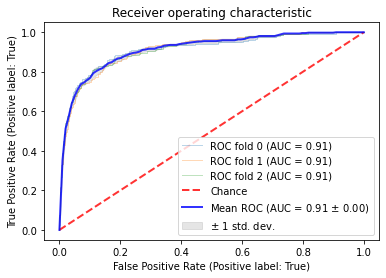

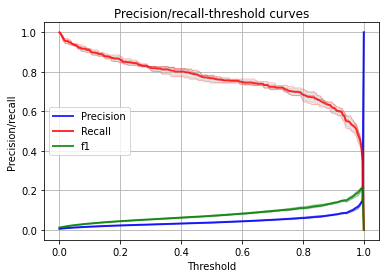

In [81]:
print_score(scores, ['accuracy','precision','recall','f1','roc_auc'], train=False)
roc_curve_cv_plot(X, y, cvsplitter, scores['estimator'])
precision_recall_cv_plot(X, y, cvsplitter, scores['estimator'], showf1=True)

### Fit on the whole dataset and save the classifier

In [82]:
classifier.fit(X, y);

filename = 'data/model.sav'
pickle.dump(classifier, open(filename, 'wb'))

### Make a query and predict

In [14]:
filename = 'data/model.sav'
classifier = pickle.load(open(filename, 'rb'))

days = 7
delta = timedelta(days = days)
categstr = '+OR+'.join(['cat:'+x for x in categories])
client = arxiv.Client()
nquery = 500
startquery = 0
lastquery = nquery
latestdate = False
maxretry = 5
predict_df = pd.DataFrame(columns = ['id','published','authors_FdotLastcomma','authors_FLast', 'title', 'abstract'])

while lastquery == nquery:
    retry = 0
    lenquery = 0
    while (retry < maxretry) and (lenquery != nquery):
        feedparser = client._parse_feed(url='http://export.arxiv.org/api/query?search_query='+categstr+'&start='+str(startquery)+'&max_results='+str(nquery)+'&sortBy=submittedDate')
        lenquery = len(feedparser['entries'])
        retry += 1
        time.sleep(10)
    if retry == maxretry:
        warnings.warn("Warning...........Maximum retries reached")
    lastquery = 0
    for entry in feedparser.entries:
        if not(latestdate): latestdate = datetime.strptime(entry.published[0:10],'%Y-%m-%d')
        if latestdate - datetime.strptime(entry.published[0:10],'%Y-%m-%d') < delta:
            lastquery += 1
            predict_df = predicted_df.append({
                'id' : entry.id,
                'authors_FdotLastcomma' : get_authors_FdotLastcomma([author['name'] for author in entry.authors]),
                'authors_FLast' : get_authors_FLast_arxivapi([author['name'] for author in entry.authors]),
                'title' : entry.title.replace('\n', ' '),
                'abstract' : entry.summary.replace('\n', ' '),
                'published': datetime.strptime(entry.published[0:10],'%Y-%m-%d')
                            }, ignore_index = True)
    startquery += nquery
    time.sleep(5)

Xnew = predict_df[['authors_FLast','title','abstract']]

predict_df['relevance'] = [x[1] for x in classifier.predict_proba(Xnew)]
print('number of the requested papers = ', predicted_df.shape[0])

predict_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].sort_values(by=['relevance'],ascending=False).head(5)

number of the requested papers =  420


,id,published,authors_FdotLastcomma,title,abstract,relevance
81,http://arxiv.org/abs/2107.03373v1,2021-07-07,"P. Bhalla, M. Deng, R. Wang, L. Wang, D. Culcer",Non-linear ballistic response of quantum spin-...,Topological edge states exhibit dissipationles...,0.999777
234,http://arxiv.org/abs/2107.02188v1,2021-07-05,"L. P. Gavensky, G. Usaj, C. A. Balseiro",Imaging chiral Andreev reflection in the prese...,"In this work, we theoretically study transvers...",0.999411
145,http://arxiv.org/abs/2107.02819v1,2021-07-06,"Z. M. Raines, D. L. Maslov, L. I. Glazman",Spin-valley Silin modes in graphene with subst...,In the presence of external magnetic field the...,0.997674
420,http://arxiv.org/abs/2107.00784v1,2021-07-02,"B. Voisin, J. Salfi, R. Rahman, S. Rogge",Novel characterisation of dopant-based qubits,Silicon is a leading qubit platform thanks to ...,0.990968
419,http://arxiv.org/abs/2107.00784v1,2021-07-02,"B. Voisin, J. Salfi, R. Rahman, S. Rogge",Novel characterisation of dopant-based qubits,Silicon is a leading qubit platform thanks to ...,0.990968


### Write predictions into 'manuscripts.db'

In [16]:
tosql_df = predicted_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].rename(columns = {"authors_FdotLastcomma": "authors"})

conn = sqlite3.connect('data/manuscripts.db')
c = conn.cursor()

c.execute('CREATE TABLE IF NOT EXISTS manuscripts (id, published, authors, title, abstract, relevance)')
conn.commit()

tosql_df.to_sql('manuscripts', conn, if_exists = 'replace', index = False)

### Write predictions into 'manuscripts.html'

In [15]:
tohtml_df = predicted_df[['id','published','authors_FdotLastcomma','title','abstract','relevance']].rename(columns = {"authors_FdotLastcomma": "authors"})

day = False
html = '<ul>\n'
html += '<hr>\n'
for idx, row in tohtml_df[tohtml_df['relevance']>0.5].sort_values(by=['published','relevance'],ascending=False).iterrows():
    if day != row['published']:
        html += '<div class="date">'+row['published'].strftime('%-d %B, %Y')+'</div>\n'
        html += '<hr>\n'
        day = row['published']
    html += '<li>\n'
    html += '<a href="'+row['id']+'">arXiv:'+row['id'].split('http://arxiv.org/abs/')[-1][:-2]+'</a>\n'
    html += '<div class="relevance"><b>Relevance:</b>'
    html += '<font style="font-family:courier, monospace">'+progress_bar(row['relevance'])+'</font>'
    html += str(round(100*row['relevance'],1))+'%</div>\n'
    html += '<div class="title"><b>Title:</b> '+row['title']+'</div>\n'
    html += '<div class="authors_head"><b>Authors:</div></b> '
    html += '<div class="authors"><i>'+row['authors']+'</i></div>\n'
    html += '<div class="abstract_head"><b>Abstract:</b></div>\n'
    html += '<div class="abstract">'+row['abstract']+'</div>\n'
    html += '<br>\n'
    html += '</li>\n'
    html += '<hr>\n'
html += '</ul>'

with open("data/template.html", "r") as file:
    template = file.read()

html = template.replace("***", html)

with open("data/manuscripts.html", "w") as file:
        file.write(html)

In [ ]:
abstract_words = classifier['preprocessor'].transformers_[2][1].get_feature_names()
abstract_idfs = classifier['preprocessor'].transformers_[2][1].idf_
abstract_tfs = classifier['preprocessor'].transformers_[2][1].transform(cited_df.abstract).sum(axis=0)
abstract_tfs = np.squeeze(np.asarray(abstract_tfs))

In [ ]:
sorted(zip(abstract_words,abstract_idfs), key = lambda x: x[1])[0:10]

In [ ]:
abstract_tfidfs = dict(zip(abstract_words,abstract_tfs*abstract_idfs))
cloud = wordcloud.WordCloud(background_color="black",
                            max_words=100,
                            width=1600,
                            height=800).generate_from_frequencies(abstract_tfidfs)

plt.figure(figsize=[20,10], facecolor='k')
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sorted(zip(abstract_words,abstract_tfs*abstract_idfs), key = lambda x: x[1],reverse=True)[0:100]